In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from ipynb.fs.full.UtilCollections import POSITIONS



Bad key text.latex.preview in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

## Load and pre process data

In [2]:
player_data = pd.read_csv("DataCollection/Player_Stats/player_stats_2021-22.csv")

In [3]:
shooting_data = pd.read_csv("DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_2021-22.csv")

In [4]:
shooting_data.columns = ["Player", "Pos", "Age", "Tm", "G", "MP", "FG%", "AvgDistance", "2PAr",
                         "0-3Ar", "3-10Ar", "10-16Ar", "16-3PAr", "3PAr", "2P%", "0-3%", "3-10%", "10-16%",
                         "16-3P%", "3P%", "2P_Assisted", "3P_Assisted", "DunksAr", "Dunks", "3PCornerAr", "3PCorner%",
                         "HeavesAttempted", "Heaves"]

In [6]:
player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

In [7]:
player_data = player_data.fillna(0)
player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
player_data = player_data.sort_values(by=['G'], ascending=False)
player_data = player_data[player_data["Tm"] != "TOT"]
player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
player_data.reset_index(inplace=True)
player_data.drop(columns=['index'], inplace=True)

## Normalize the data

In [8]:
features = player_data.loc[:, ~player_data.columns.isin(["Player", "Pos", "Tm"])].values
x = StandardScaler().fit_transform(features)

## Reduce Dimensionality to 2 components

In [15]:
pca = PCA(n_components=2)
components = pca.fit_transform(x)

componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
df = pd.concat([componentsDf, player_data[['Pos', "Player"]]], axis = 1)

### Plot 2D PCA

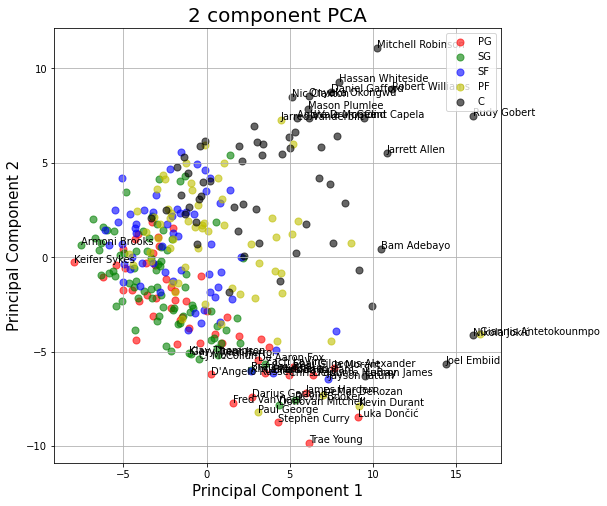

In [16]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['PG', 'SG', 'SF', 'PF', 'C']
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = df['Pos'] == target
    ax.scatter(df.loc[indicesToKeep, 'PC1'], df.loc[indicesToKeep, 'PC2'], 
               c=color, s=50, alpha=.6)
ax.legend(targets)
ax.grid()

for i, data in df.iterrows():
    if data["PC1"] < -7 or data["PC2"] > 7 or data["PC1"] > 10 or data["PC2"] < -5:
        ax.annotate(data["Player"], (data["PC1"], data["PC2"]))

# Clustering

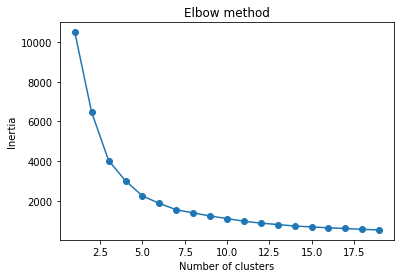

In [31]:
data = list(zip(df["PC1"], df["PC2"]))

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

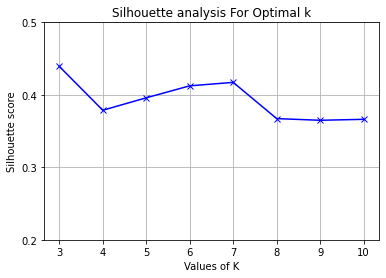

In [32]:
range_n_clusters = [3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg = []
for num_clusters in range_n_clusters: 
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_

    silhouette_avg.append(silhouette_score(data, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.grid()
plt.yticks(np.arange(0.2, 0.6, 0.1))
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

## Run K-means

In [19]:
CLUSTERS = 7

In [33]:
kmeans = KMeans(n_clusters=CLUSTERS)
kmeans.fit(data)
cmap = plt.cm.get_cmap('Dark2', CLUSTERS)
df['Cluster'] = kmeans.labels_

## Plot K-means

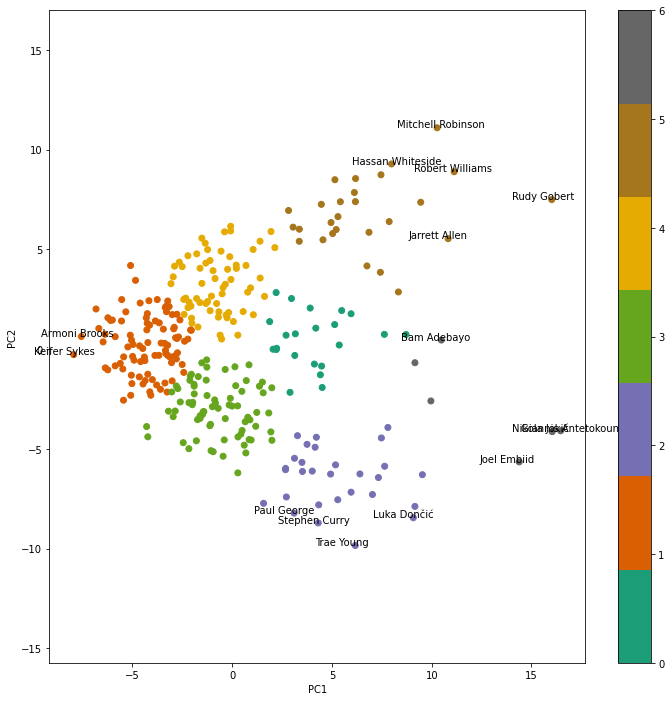

In [34]:
plt.figure(figsize=(12, 12))
plt.scatter(df["PC1"], df["PC2"], c=df['Cluster'], cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
for i, row in df.iterrows():
    if row["PC1"] < -7 or row["PC2"] > 9 or row["PC1"] > 10 or row["PC2"] < -8:
        plt.text(row["PC1"]-2, row["PC2"], row["Player"])
plt.axis('equal')
plt.colorbar(ticks=range(CLUSTERS))
plt.show()

## Group by clusters, find distribution of the positions in each cluster

In [35]:
clustered_df = df.groupby(["Cluster", "Pos"]).count()[["Player"]]

In [36]:
for i, row in clustered_df.iterrows():
    clustered_df.loc[i, "Position%"] = row['Player'] / clustered_df.loc[i[0]].sum()['Player']

In [37]:
position_percentages = {}

for p in POSITIONS:
    position_percentages[p] = []

for i in range(CLUSTERS):
    cluster = clustered_df.loc[i]
    for p in POSITIONS:
        if p in list(cluster.index):
            position_percentages[p].append(cluster.loc[p]['Position%'])
        else:
            position_percentages[p].append(0)

## Plot player distribution as cummulative bar charts

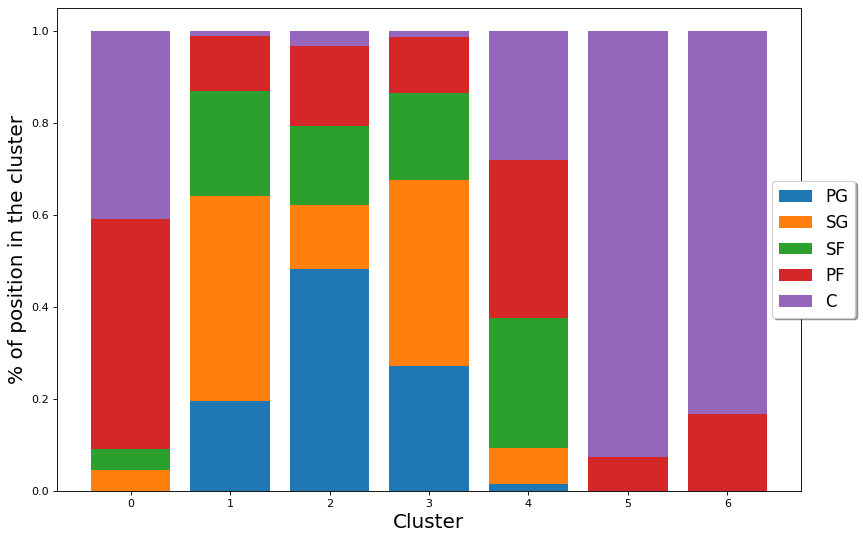

In [38]:
plt.figure(figsize=(12, 8), dpi=80)

counter = np.zeros(CLUSTERS)

for position in POSITIONS:
    plt.bar(range(CLUSTERS), position_percentages[position], bottom=counter, label=position)
    counter += np.array(position_percentages[position])

plt.xlabel("Cluster", fontsize=18)
plt.ylabel("% of position in the cluster", fontsize=18)
plt.xticks(range(CLUSTERS))
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),
          fancybox=True, shadow=True, ncol=1, prop={'size': 15})
plt.savefig("Results/Clustering/PositionsDistributionInClustering.jpg", bbox_inches='tight')
plt.show()

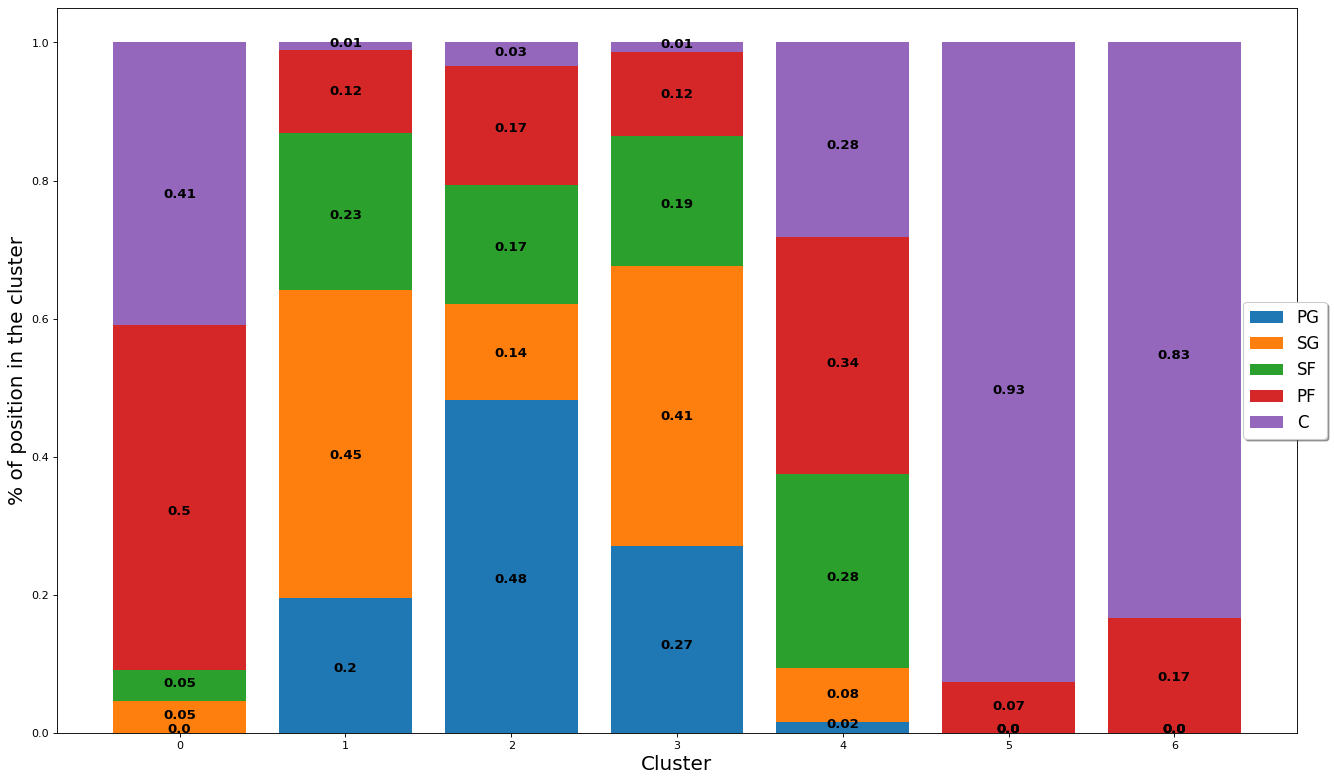

In [39]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=80)

counter = np.zeros(CLUSTERS)

for position in POSITIONS:
    ax.bar(range(CLUSTERS), position_percentages[position], bottom=counter, label=position)
    counter += np.array(position_percentages[position])
    
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, 
            bar.get_y() + (bar.get_height() * 0.45), 
            round(bar.get_height(),2), 
            ha='center', color='black', weight='bold', size=12)
    
ax.set_xlabel("Cluster", fontsize=18)
ax.set_ylabel("% of position in the cluster", fontsize=18)
ax.set_xticks(range(CLUSTERS))
ax.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),
          fancybox=True, shadow=True, ncol=1, prop={'size': 15})
plt.savefig("Results/Clustering/PositionsDistributionInClustering_withCounters.jpg", bbox_inches='tight')
plt.show()

## Randomizing PCA features

In [29]:
def run_random_pca(df, non_feature_cols, target):
    features = df.loc[:, ~df.columns.isin(non_feature_cols)]
    random_selector = np.random.choice(a=[False, True], size=len(features.columns), p=[.5, .5])
    random_features_df = features.loc[:, random_selector]
    selected_features = list(random_features_df.columns)
    random_features = random_features_df.values        
    random_features = StandardScaler().fit_transform(random_features)
    
    if random_features.shape[1] <= 0.45 * len(features.columns):
        return None, None
    
    pca = PCA(2)
    components = pca.fit_transform(random_features)
    components_df = pd.DataFrame(data=components, columns=["PC1", "PC2"])
    components_df = pd.concat([components_df, df[target]], axis=1)
    var = pca.explained_variance_ratio_
    return components_df, [selected_features, len(selected_features), var[0], var[1], sum(var)]

In [30]:
def iterate_random_pcas(df, non_feature_cols, target, iterations, csv):
    PCAs = pd.DataFrame(columns=["Features", "Features Count", "PC1 var", "PC2 var", "Total explained variance ratio"])
    for i in range(iterations):
        pca_df, pca_stats = run_random_pca(df, non_feature_cols, target)
        if pca_df is not None:
            pca_row = {'Features': ' '.join(pca_stats[0]),
                       'Features Count': pca_stats[1],
                       'PC1 var': pca_stats[2],
                       'PC2 var': pca_stats[3],
                       'Total explained variance ratio': pca_stats[4]}
            PCAs = PCAs.append(pca_row, ignore_index=True)
    PCAs.to_csv(f"DataCollection/PCA/{csv}.csv", index=False)

## Run 10.000 random PCAs, find the ones with highes Explained Variance Ratio

In [15]:
iterate_random_pcas(player_data, ["Player", "Pos", "Tm"], ["Player", "Pos"], 10**5, "PlayerAndShooting")

In [16]:
PCAs = pd.read_csv("DataCollection/PCA/PlayerAndShooting.csv")

In [17]:
PCAs.sort_values(by='Total explained variance ratio', ascending=False, inplace=True)

In [63]:
PCAs.head()

,Features,Features Count,PC1 var,PC2 var,Total explained variance ratio
20532,Age GS MP FG FGA FG% 3PA 3P% 2P 2PA FT FTA FT%...,32,0.384231,0.276060,0.660291
52191,G GS FG FGA 3P 3PA 3P% 2P 2PA 2P% FT ORB DRB T...,32,0.405493,0.244667,0.650160
41234,MP FG FGA FG% 3P 3PA 2P 2PA 2P% FTA FT% ORB DR...,31,0.393492,0.256635,0.650127
26599,FGA FG% 3P 2P 2PA eFG% FT FTA ORB DRB TRB AST ...,31,0.408729,0.240479,0.649208
31408,MP FGA FG% 3P% 2P% eFG% FT FTA FT% ORB DRB TRB...,31,0.361829,0.286627,0.648456


In [50]:
features = player_data[PCAs.iloc[3]['Features'].split()] 
x = StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
components = pca.fit_transform(x)

componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
df = pd.concat([componentsDf, player_data[['Pos', "Player"]]], axis = 1)

### Plot the chosen PCA

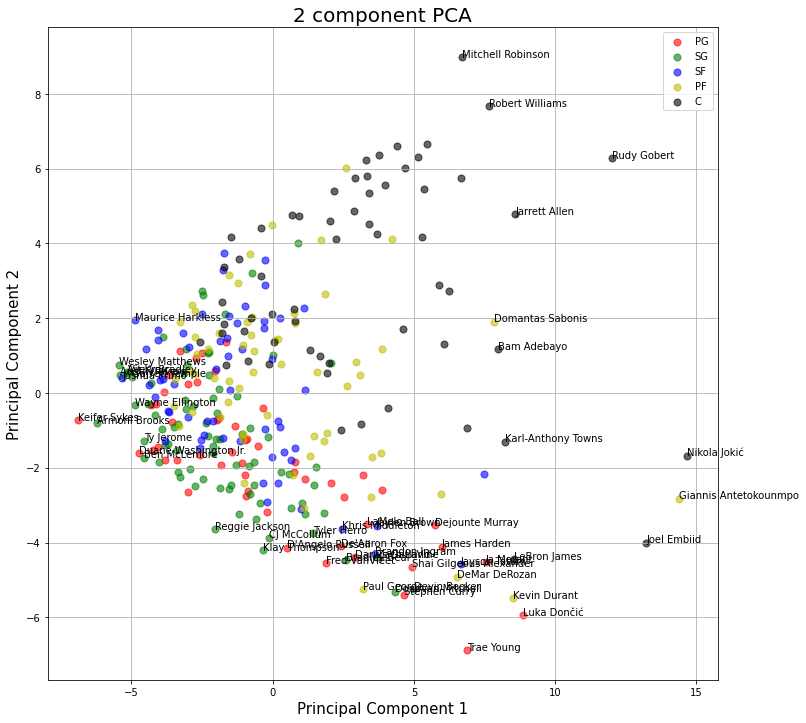

In [51]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['PG', 'SG', 'SF', 'PF', 'C']
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = df['Pos'] == target
    ax.scatter(df.loc[indicesToKeep, 'PC1'], df.loc[indicesToKeep, 'PC2'], 
               c=color, s=50, alpha=.6)
ax.legend(targets)
ax.grid()

for i, data in df.iterrows():
    if data["PC1"] < -4.5 or data["PC2"] > 7.5 or data["PC1"] > 7.5 or data["PC2"] < -3.5:
        ax.annotate(data["Player"], (data["PC1"], data["PC2"]))

## Run k-means clustering for the previous PCA

C:\Users\140775\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


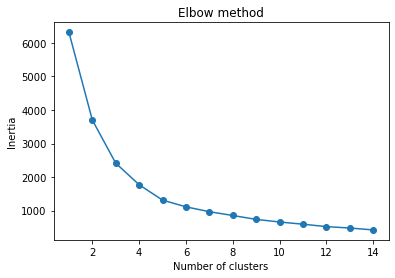

In [52]:
data = list(zip(df["PC1"], df["PC2"]))

inertias = []

for i in range(1,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,15), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

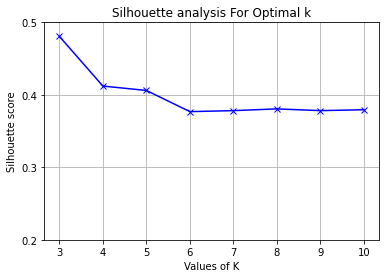

In [53]:
range_n_clusters = [3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg = []
for num_clusters in range_n_clusters: 
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_

    silhouette_avg.append(silhouette_score(data, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.grid()
plt.yticks(np.arange(0.2, 0.6, 0.1))
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [66]:
CLUSTERS = 7

In [67]:
kmeans = KMeans(n_clusters=CLUSTERS)
kmeans.fit(data)
cmap = plt.cm.get_cmap('Dark2', CLUSTERS)
df['Cluster'] = kmeans.labels_

## Plot K-means

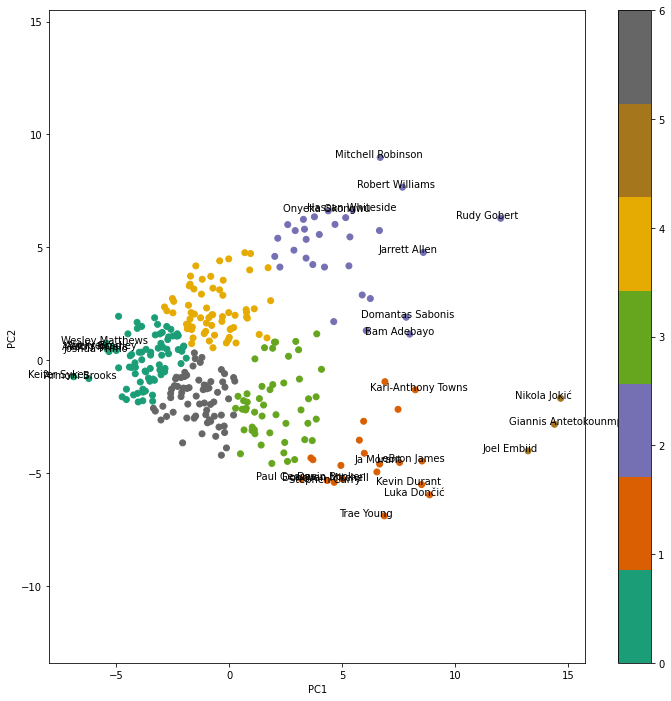

In [68]:
plt.figure(figsize=(12, 12))
plt.scatter(df["PC1"], df["PC2"], c=df['Cluster'], cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
for i, row in df.iterrows():
    if row["PC1"] < -5 or row["PC2"] > 6.5 or row["PC1"] > 7.5 or row["PC2"] < -5:
        plt.text(row["PC1"]-2, row["PC2"], row["Player"])
plt.axis('equal')
plt.colorbar(ticks=range(CLUSTERS))
plt.show()

## Group by clusters, find distribution of the positions in each cluster

In [57]:
clustered_df = df.groupby(["Cluster", "Pos"]).count()[["Player"]]

In [58]:
for i, row in clustered_df.iterrows():
    clustered_df.loc[i, "Position%"] = row['Player'] / clustered_df.loc[i[0]].sum()['Player']

In [59]:
position_percentages = {}

for p in POSITIONS:
    position_percentages[p] = []

for i in range(CLUSTERS):
    cluster = clustered_df.loc[i]
    for p in POSITIONS:
        if p in list(cluster.index):
            position_percentages[p].append(cluster.loc[p]['Position%'])
        else:
            position_percentages[p].append(0)

## Plot player distribution as cummulative bar charts

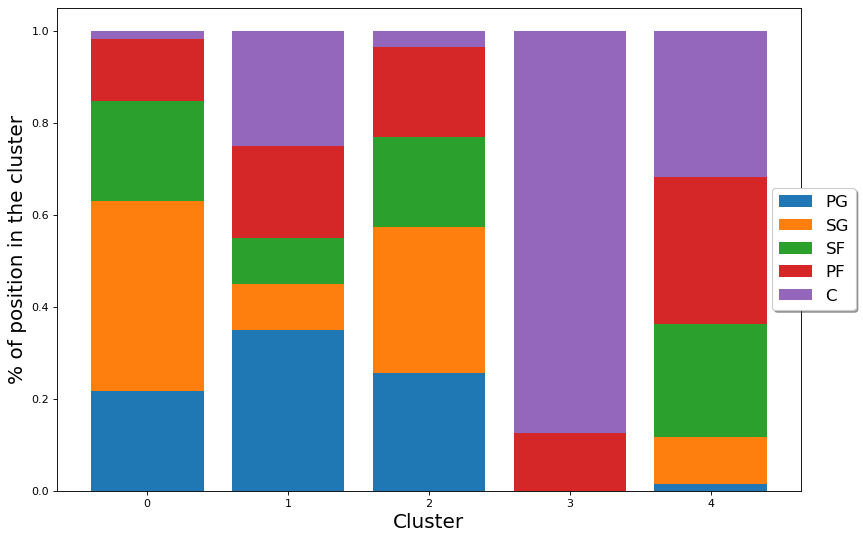

In [60]:
plt.figure(figsize=(12, 8), dpi=80)

counter = np.zeros(CLUSTERS)

for position in POSITIONS:
    plt.bar(range(CLUSTERS), position_percentages[position], bottom=counter, label=position)
    counter += np.array(position_percentages[position])

plt.xlabel("Cluster", fontsize=18)
plt.ylabel("% of position in the cluster", fontsize=18)
plt.xticks(range(CLUSTERS))
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),
          fancybox=True, shadow=True, ncol=1, prop={'size': 15})
plt.savefig("Results/Clustering/PositionsDistributionInClustering.jpg", bbox_inches='tight')
plt.show()

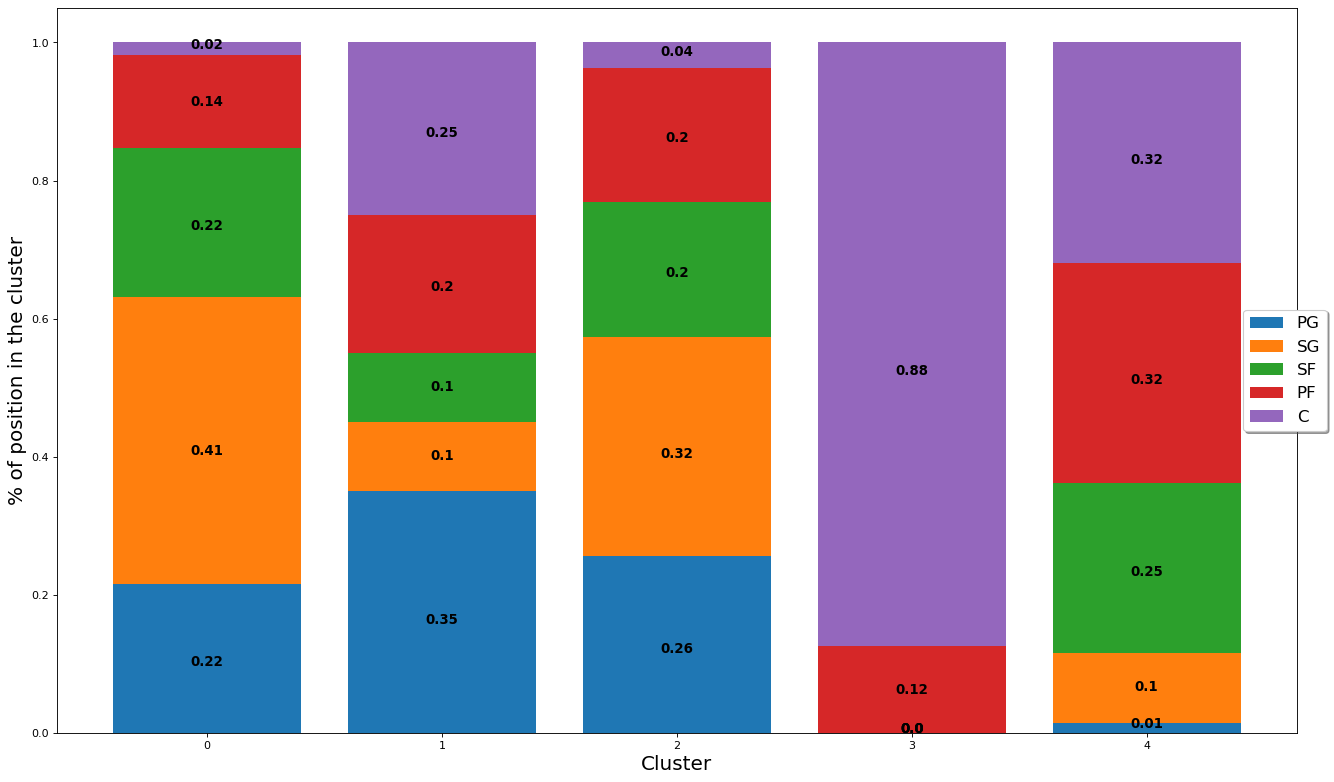

In [61]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=80)

counter = np.zeros(CLUSTERS)

for position in POSITIONS:
    ax.bar(range(CLUSTERS), position_percentages[position], bottom=counter, label=position)
    counter += np.array(position_percentages[position])
    
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, 
            bar.get_y() + (bar.get_height() * 0.45), 
            round(bar.get_height(),2), 
            ha='center', color='black', weight='bold', size=12)
    
ax.set_xlabel("Cluster", fontsize=18)
ax.set_ylabel("% of position in the cluster", fontsize=18)
ax.set_xticks(range(CLUSTERS))
ax.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),
          fancybox=True, shadow=True, ncol=1, prop={'size': 15})
plt.savefig("Results/Clustering/PositionsDistributionInClustering_withCounters.jpg", bbox_inches='tight')
plt.show()